In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from config import am_key
from census import Census
from us import states

# Census API Key
from config import c_key


c = Census(c_key, year=2018)

In [2]:
#Read in 4 parts of bus data csv

bus1 = pd.read_csv(r'../CSVs/filter_bus_1000.csv')
bus2 = pd.read_csv(r'../CSVs/new_bus_2.csv')
bus3 = pd.read_csv(r'../CSVs/filter_bus_3001-4500.csv')
bus4 = pd.read_csv(r'../CSVs/filter_bus_4500-5535.csv')

In [3]:
#concat 4 csvs into 1 df with zipcodes and all bus stops
all_bus_stops = pd.concat([bus1, bus2, bus3, bus4])

In [4]:
#delete unnecessary columns
del all_bus_stops['Zipcode']
del all_bus_stops['X']
del all_bus_stops['Y']
del all_bus_stops['NoName']
del all_bus_stops['NextRide']
del all_bus_stops['Juris']
del all_bus_stops['WaterFountain']
del all_bus_stops['ADA']
del all_bus_stops['ATIS_ID']
del all_bus_stops['Lat']
del all_bus_stops['Long']
del all_bus_stops['Routes']
del all_bus_stops['Zip']
del all_bus_stops['City']
del all_bus_stops['ComputedZipPlus4']
del all_bus_stops['Column1']
del all_bus_stops['StreetAddress']

del all_bus_stops['AUTO_UNIQUE_ID_2020-07-28_smavila1_new_bus_2']
del all_bus_stops['OBJECTID']
del all_bus_stops['DateUpdated']
del all_bus_stops['AUTO_UNIQUE_ID_2020-07-27_cceni03_filter_bus3001']
del all_bus_stops['AUTO_UNIQUE_ID_2020-07-28_czc5230_bus_4']
del all_bus_stops['AUTO_UNIQUE_ID_2020-07-27_pwewiora08_filter_bus_1000']
del all_bus_stops['Direction']
del all_bus_stops['State']
del all_bus_stops['Address']
del all_bus_stops['Type_']

del all_bus_stops['UpdatedReverseGeocoding']

del all_bus_stops['TimeTaken']
del all_bus_stops['TransactionId']
del all_bus_stops['Source']
del all_bus_stops['ErrorMessage']
del all_bus_stops['Version']
del all_bus_stops['ComputedAPN']


In [5]:
#clean up & save new csv
all_bus_stops = all_bus_stops.rename(columns ={'ComputedZip':'Zipcode'})

all_bus_stops.to_csv(r'../PW_CSVs/all_bus_stops.csv')

all_bus_stops

,StopID,Location,ComputedStreetAddress,ComputedCity,ComputedState,Zipcode
0,5182.0,MESA DR & MAIN ST,315 E MAIN ST,Globe,AZ,85201.0
1,2982.0,MESA DR & MAIN ST,410 E MAIN ST,Mesa,AZ,85203.0
2,4681.0,MESA DR & 6TH ST,520 N MESA DR,Globe,AZ,85201.0
3,4682.0,MESA DR & UNIVERSITY DR,310 N MESA DR,Globe,AZ,85201.0
4,4679.0,MESA DR & 1ST ST,307 E 1ST ST,Globe,AZ,85201.0
...,...,...,...,...,...,...
1030,5069.0,COUNTRY CLUB DR & DANA AVE,126 S COUNTRY CLUB DR,Apache Junction,AZ,85210.0
1031,30430.0,E. Continental Dr. & N. McAllister Ave.,515 E CONTINENTAL DR,Mesa,AZ,85281.0
1032,NaN,S. Smith St. & E. University Dr.,2010 E UNIVERSITY DR,Mesa,AZ,85281.0
1033,40272.0,Desert Foothills Pkwy & S 16013,16013 S DESERT FOOTHILLS PKWY,Phoenix,AZ,85048.0


In [6]:
#read in CSV with ridership data
bus_riders = pd.read_csv(r'../CSVs/Valley_Metro_Bus_Ridership.csv')

#merge with bus stop df that has zipcodes
bus_riders = pd.merge(bus_riders, all_bus_stops, how = 'left', on = 'StopID')

In [7]:
#delete unnecessary columns
del bus_riders['Location_x']

del bus_riders['Photo']
del bus_riders['Routes']
del bus_riders['OBJECTID']


del bus_riders['NextRide']
del bus_riders['Location_y']



In [8]:
#save csv
bus_riders.to_csv(r'../PW_CSVs/bus_riders.csv')

bus_riders

,StopID,Juris,Day_Category,Q2016_2,Q2016_3,Q2016_4,Q2017_1,Q2017_2,Q2017_3,Q2017_4,Q2018_12,Q2018_2,Q2018_3,Q42018,Q2019_1,Q2019_2,ComputedStreetAddress,ComputedCity,ComputedState,Zipcode
0,5182,Mesa,Weekend,7.0,7.0,6.0,4.0,7.0,6.0,8.0,12.0,5.0,10.0,11.0,9.0,8.0,315 E MAIN ST,Globe,AZ,85201.0
1,2982,Mesa,Weekend,7.0,6.0,6.0,4.0,4.0,5.0,6.0,10.0,5.0,9.0,6.0,6.0,7.0,410 E MAIN ST,Mesa,AZ,85203.0
2,4681,Mesa,Weekend,0.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0,520 N MESA DR,Globe,AZ,85201.0
3,4682,Mesa,Weekend,4.0,4.0,4.0,2.0,4.0,3.0,5.0,7.0,3.0,6.0,5.0,4.0,6.0,310 N MESA DR,Globe,AZ,85201.0
4,4679,Mesa,Weekend,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,307 E 1ST ST,Globe,AZ,85201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15149,7775,Phoenix,Weekday,29.0,29.0,29.0,75.0,48.0,88.0,78.0,136.0,75.0,215.0,91.0,79.0,78.0,10 W BROADWAY RD,Phoenix,AZ,85041.0
15150,7781,Phoenix,Weekday,10.0,10.0,11.0,29.0,19.0,41.0,42.0,59.0,32.0,81.0,40.0,52.0,41.0,10 W BROADWAY RD,Phoenix,AZ,85041.0
15151,7782,Phoenix,Weekday,10.0,10.0,10.0,25.0,15.0,30.0,25.0,51.0,26.0,69.0,28.0,27.0,26.0,10 W BROADWAY RD,Phoenix,AZ,85041.0
15152,565,Phoenix,Weekday,35.0,35.0,36.0,98.0,56.0,105.0,102.0,164.0,80.0,153.0,98.0,85.0,88.0,4704 E PARADISE VILLAGE PKWY N,Phoenix,AZ,85032.0


In [9]:
#run census API
census_data = c.acs5.get(('B19301_001E', 
                          'B01003_001E',"B17001_002E"), {'for': 'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

#B19301_001E = Per Capita Income
#B01003_001E = total population
#B17001_002E = poverty count

In [10]:
# Column Renaming
census_pd = census_pd.rename(columns={"B19301_001E" : "Per Capita Income",
                                      "B17001_002E" : "Poverty Count",
                                      "B01003_001E" : "Population",
                                      "zip code tabulation area": "Zipcode"})
#remove NAN
census_pd = census_pd.fillna(0)

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

#convert data types to be able to merge these two dfs 
census_pd['Zipcode'] = census_pd['Zipcode'].transform(float)

bus_riders['Zipcode']= pd.to_numeric(bus_riders['Zipcode'], errors='coerce').fillna(0).astype(float)


In [11]:
#merge census data with bus ridership and bus stop data.
bus_census = pd.merge(bus_riders, census_pd, how='left', on=['Zipcode'])
bus_census.to_csv(r'../PW_CSVs/bus_census.csv')
bus_census.rename(columns = {'Day_Category': 'Day'}, inplace = True)

#cleaning up dataset
del bus_census['Q2016_2']
del bus_census['Q2016_3']
del bus_census['Q2016_4']
del bus_census['Q2017_1']
del bus_census['Q2017_2']
del bus_census['Q2017_3']
del bus_census['Q2017_4']
del bus_census['Q2019_1']
del bus_census['Q2019_2']


In [12]:
bus_census

,StopID,Juris,Day,Q2018_12,Q2018_2,Q2018_3,Q42018,ComputedStreetAddress,ComputedCity,ComputedState,Zipcode,Per Capita Income,Population,Poverty Count,Poverty Rate
0,5182,Mesa,Weekend,12.0,5.0,10.0,11.0,315 E MAIN ST,Globe,AZ,85201.0,19882.0,51519.0,12469.0,24.202721
1,2982,Mesa,Weekend,10.0,5.0,9.0,6.0,410 E MAIN ST,Mesa,AZ,85203.0,24339.0,39069.0,6481.0,16.588600
2,4681,Mesa,Weekend,2.0,1.0,1.0,2.0,520 N MESA DR,Globe,AZ,85201.0,19882.0,51519.0,12469.0,24.202721
3,4682,Mesa,Weekend,7.0,3.0,6.0,5.0,310 N MESA DR,Globe,AZ,85201.0,19882.0,51519.0,12469.0,24.202721
4,4679,Mesa,Weekend,1.0,0.0,0.0,1.0,307 E 1ST ST,Globe,AZ,85201.0,19882.0,51519.0,12469.0,24.202721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15149,7775,Phoenix,Weekday,136.0,75.0,215.0,91.0,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299
15150,7781,Phoenix,Weekday,59.0,32.0,81.0,40.0,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299
15151,7782,Phoenix,Weekday,51.0,26.0,69.0,28.0,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299
15152,565,Phoenix,Weekday,164.0,80.0,153.0,98.0,4704 E PARADISE VILLAGE PKWY N,Phoenix,AZ,85032.0,27780.0,72830.0,11763.0,16.151311


In [13]:
#narrow datasat to just Phoenix jurisdiction and within the city of phoenix
phx_j = bus_census.loc[:,'Juris'] == 'Phoenix'

phx_juris = bus_census[phx_j]

phx_city = phx_juris.loc[:,'ComputedCity'] == 'Phoenix'
phx_bus = phx_juris[phx_city]

In [14]:
#narrow dataset to just weekday averages.
#bus_weekday = phx_bus.loc[:,'Day'] == 'Weekday'

#weekday_riders = phx_bus[bus_weekday]

#weekday_riders

In [15]:
#narrow dataset to just weekend ridership
#bus_weekend = phx_bus.loc[:,'Day'] == 'Weekend'

#weekend_riders = phx_bus[bus_weekend]

#weekend_riders

In [16]:
#find average ridership for 2018 from the 4 quarters.
phx2018columns = ['Q2018_12', 'Q22018_2', 'Q2018_3', 'Q42018']

phx2018 = phx_bus.reindex(columns = phx2018columns)


In [17]:
#take the mean of 2018 instead of using 4 quarters and create new column with this data.
df = phx2018.mean(axis=1)
df
phx_bus['2018'] = df
del phx_bus['Q2018_12']
del phx_bus['Q2018_2']
del phx_bus['Q2018_3']
del phx_bus['Q42018']

phx_bus


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,StopID,Juris,Day,ComputedStreetAddress,ComputedCity,ComputedState,Zipcode,Per Capita Income,Population,Poverty Count,Poverty Rate,2018
3543,8780,Phoenix,Weekend,7050 S 24TH ST,Phoenix,AZ,85042.0,23442.0,46570.0,8510.0,18.273567,1.333333
3544,8783,Phoenix,Weekend,341 W MCDOWELL RD,Phoenix,AZ,85003.0,37766.0,8419.0,1652.0,19.622283,2.000000
3545,8785,Phoenix,Weekend,7435 W LOWER BUCKEYE RD,Phoenix,AZ,85043.0,16552.0,39757.0,8823.0,22.192318,27.333333
3547,8793,Phoenix,Weekend,506 W MCDOWELL RD,Phoenix,AZ,85003.0,37766.0,8419.0,1652.0,19.622283,0.666667
3548,8796,Phoenix,Weekend,19801 N TATUM BLVD,Phoenix,AZ,85050.0,48804.0,30647.0,1873.0,6.111528,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
15149,7775,Phoenix,Weekday,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299,147.333333
15150,7781,Phoenix,Weekday,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299,60.000000
15151,7782,Phoenix,Weekday,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,14315.0,22.907299,49.333333
15152,565,Phoenix,Weekday,4704 E PARADISE VILLAGE PKWY N,Phoenix,AZ,85032.0,27780.0,72830.0,11763.0,16.151311,138.333333


In [18]:
#save new csv
phx_bus.rename(columns ={'2018': 'Mean Daily Riders 2018'})
phx_bus.to_csv(r'../PW_CSVs/phx_bus.csv')

In [19]:
#filter for just weekday ridership
bus_weekday = phx_bus.loc[:,'Day'] == 'Weekday'

weekday_riders = phx_bus[bus_weekday]

weekday_riders

#filter for just weekend ridership
bus_weekend = phx_bus.loc[:,'Day'] == 'Weekend'

weekend_riders = phx_bus[bus_weekend]

del weekend_riders ['Poverty Count']
weekend_riders

,StopID,Juris,Day,ComputedStreetAddress,ComputedCity,ComputedState,Zipcode,Per Capita Income,Population,Poverty Rate,2018
3543,8780,Phoenix,Weekend,7050 S 24TH ST,Phoenix,AZ,85042.0,23442.0,46570.0,18.273567,1.333333
3544,8783,Phoenix,Weekend,341 W MCDOWELL RD,Phoenix,AZ,85003.0,37766.0,8419.0,19.622283,2.000000
3545,8785,Phoenix,Weekend,7435 W LOWER BUCKEYE RD,Phoenix,AZ,85043.0,16552.0,39757.0,22.192318,27.333333
3547,8793,Phoenix,Weekend,506 W MCDOWELL RD,Phoenix,AZ,85003.0,37766.0,8419.0,19.622283,0.666667
3548,8796,Phoenix,Weekend,19801 N TATUM BLVD,Phoenix,AZ,85050.0,48804.0,30647.0,6.111528,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
7572,7775,Phoenix,Weekend,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,22.907299,49.333333
7573,7781,Phoenix,Weekend,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,22.907299,28.666667
7574,7782,Phoenix,Weekend,10 W BROADWAY RD,Phoenix,AZ,85041.0,19436.0,62491.0,22.907299,15.000000
7575,565,Phoenix,Weekend,4704 E PARADISE VILLAGE PKWY N,Phoenix,AZ,85032.0,27780.0,72830.0,16.151311,72.666667


The r-squared is: 0.061275235100447446


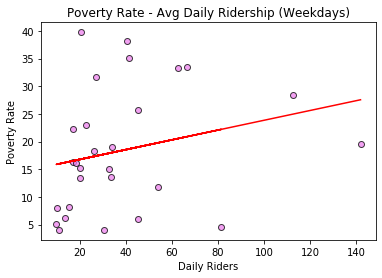

In [20]:
#group data by zipcode and provide agg to analyze by zipcode
weekday_bus = weekday_riders.drop_duplicates( subset='StopID', keep="first", inplace=False)

weekday_bus

weekday = weekday_bus.groupby('Zipcode').agg({
    'StopID':'count',
    'ComputedStreetAddress':'count',
    'ComputedCity':'first',
    'Juris':'first',
    'Day':'first',
    'Per Capita Income': 'mean',
    'Population': 'first',
    'Poverty Rate': 'first',
    '2018':'mean'
})



weekday

#weekday poverty rate by ridership numbers
plt.scatter(weekday['2018'],weekday['Poverty Rate'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Poverty Rate - Avg Daily Ridership (Weekdays)")
plt.xlabel("Daily Riders")
plt.ylabel("Poverty Rate")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekday['2018'], weekday['Poverty Rate'])
regress_values = weekday['2018'] * slope + intercept

# Plot regression line
plt.plot(weekday['2018'],regress_values,"r-")


#finding R^2

np.corrcoef(weekday.loc[:,'Poverty Rate'], regress_values)[0,1]**2
print(f"The r-squared is: {rvalue**2}")
plt.savefig('../PW_CSVs/poverty_riders_weekday')


The r-squared is: 0.17384680547873713


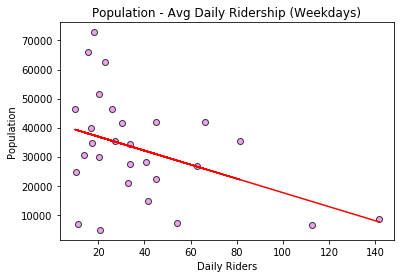

In [21]:
#weekday population by ridership numbers
plt.scatter(weekday['2018'],weekday['Population'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Population - Avg Daily Ridership (Weekdays)")
plt.xlabel("Daily Riders")
plt.ylabel("Population")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekday['2018'], weekday['Population'])
regress_values = weekday['2018'] * slope + intercept

# Plot regression line
plt.plot(weekday['2018'],regress_values,"r-")


#finding R^2
np.corrcoef(weekday.loc[:,'Population'], regress_values)[0,1]**2
#print R^2
print(f"The r-squared is: {rvalue**2}")

#save figure
plt.savefig('../PW_CSVs/population_riders_weekday')

The r-squared is: 0.0009199194805754418


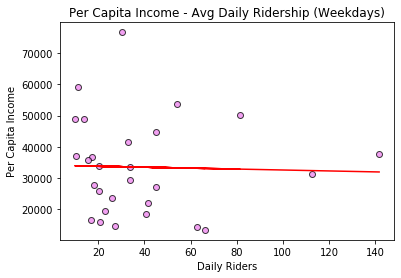

In [22]:
#plot per capita income by 2018 rider numbers
plt.scatter(weekday['2018'],weekday['Per Capita Income'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Per Capita Income - Avg Daily Ridership (Weekdays)")
plt.xlabel("Daily Riders")
plt.ylabel("Per Capita Income")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekday['2018'], weekday['Per Capita Income'])
regress_values = weekday['2018'] * slope + intercept

# Plot regression line
plt.plot(weekday['2018'],regress_values,"r-")

#finding R^2
#print R^2
#save figure
np.corrcoef(weekday.loc[:,'Per Capita Income'], regress_values)[0,1]**2
print(f"The r-squared is: {rvalue**2}")
plt.savefig('../PW_CSVs/income_riders_weekday')

The r-squared is: 0.14855305804651214


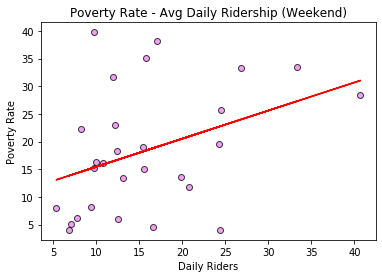

In [23]:
#group weekend rider numbers by zip code and agg columns values to analyze
weekend_bus = weekend_riders.drop_duplicates( subset='StopID', keep="first", inplace=False)

weekend = weekend_bus.groupby('Zipcode').agg({
    'StopID':'count',
    'ComputedStreetAddress':'count',
    'ComputedCity':'first',
    'Juris':'first',
    'Day':'first',
    'Per Capita Income': 'mean',
    'Population': 'first',
    'Poverty Rate': 'first',
    '2018':'mean'
})

#plot weekend poverty rate by rider #s
plt.scatter(weekend['2018'],weekend['Poverty Rate'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Poverty Rate - Avg Daily Ridership (Weekend)")
plt.xlabel("Daily Riders")
plt.ylabel("Poverty Rate")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekend['2018'], weekend['Poverty Rate'])
regress_values = weekend['2018'] * slope + intercept

# Plot regression line
plt.plot(weekend['2018'],regress_values,"r-")


#finding R^2
#print R^2
#save figure
np.corrcoef(weekend.loc[:,'Poverty Rate'], regress_values)[0,1]**2

print(f"The r-squared is: {rvalue**2}")
plt.savefig('../PW_CSVs/poverty_riders_weekend')

The r-squared is: 0.05739642693461442


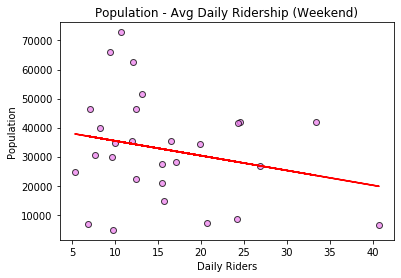

In [24]:
#weekend population by rider #s
plt.scatter(weekend['2018'],weekend['Population'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Population - Avg Daily Ridership (Weekend)")
plt.xlabel("Daily Riders")
plt.ylabel("Population")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekend['2018'], weekend['Population'])
regress_values = weekend['2018'] * slope + intercept

# Plot regression line
plt.plot(weekend['2018'],regress_values,"r-")

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(6,10),fontsize=15,color="red")


#finding R^2
#print R^2
#save figure
np.corrcoef(weekend.loc[:,'Population'], regress_values)[0,1]**2

print(f"The r-squared is: {rvalue**2}")

plt.savefig('../PW_CSVs/population_riders_weekend')

The r-squared is: 0.00853884001461299


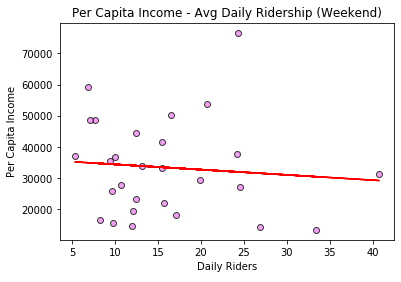

In [25]:
#weekend per capita income by rider numbers
plt.scatter(weekend['2018'],weekend['Per Capita Income'], marker="o", facecolors="violet", edgecolors="black",
            alpha=0.75)

plt.title("Per Capita Income - Avg Daily Ridership (Weekend)")
plt.xlabel("Daily Riders")
plt.ylabel("Per Capita Income")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(weekend['2018'], weekend['Per Capita Income'])
regress_values = weekend['2018'] * slope + intercept

# Plot regression line
plt.plot(weekend['2018'],regress_values,"r-")

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(6,10),fontsize=15,color="red")


#finding R^2
#print R^2
#save figure
np.corrcoef(weekend.loc[:,'Per Capita Income'], regress_values)[0,1]**2

print(f"The r-squared is: {rvalue**2}")

plt.savefig('../PW_CSVs/income_riders_weekend')